<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_5_Deep_Learning_and_Hybrid_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn tensorflow prophet xgboost neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >=

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from prophet import Prophet
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet
import torch
import matplotlib.pyplot as plt

# APPROACH 1: Comprehensive allowlisting with dynamic import handling
def safe_import_and_allowlist():
    """Dynamically import and allowlist NeuralProphet components"""
    components_to_allowlist = []

    # Try to import all known NeuralProphet components
    neuralprophet_imports = [
        ('neuralprophet.configure', ['ConfigSeasonality', 'Train', 'Season', 'Trend', 'AR', 'Normalization']),
        ('neuralprophet.df_utils', ['ShiftScale']),
        ('neuralprophet.time_net', ['TimeNet']),
        ('neuralprophet.components', ['Components']),
    ]

    for module_name, class_names in neuralprophet_imports:
        try:
            module = __import__(module_name, fromlist=class_names)
            for class_name in class_names:
                if hasattr(module, class_name):
                    components_to_allowlist.append(getattr(module, class_name))
                    print(f"✓ Added {module_name}.{class_name} to allowlist")
        except ImportError as e:
            print(f"⚠ Could not import {module_name}: {e}")

    # Add PyTorch and NumPy components
    pytorch_numpy_components = [
        torch.nn.modules.loss.SmoothL1Loss,
        torch.optim.AdamW,
        torch.optim.lr_scheduler.OneCycleLR,
        np.core.multiarray._reconstruct,
        np.ndarray,
        np.dtype,
        np.dtypes.Float64DType
    ]

    components_to_allowlist.extend(pytorch_numpy_components)

    # Apply the allowlist
    torch.serialization.add_safe_globals(components_to_allowlist)
    print(f"✓ Total components allowlisted: {len(components_to_allowlist)}")

# APPROACH 2: Context manager for weights_only=False (recommended)
from contextlib import contextmanager

@contextmanager
def allow_unsafe_loading():
    """Context manager to temporarily disable weights_only for trusted libraries"""
    original_load = torch.load
    def patched_load(*args, **kwargs):
        kwargs.setdefault('weights_only', False)
        return original_load(*args, **kwargs)

    torch.load = patched_load
    try:
        yield
    finally:
        torch.load = original_load

# APPROACH 3: Simple global override (fastest)
# Uncomment this line if you want the simplest solution:
# torch.serialization._set_default_load_args({'weights_only': False})

# Use the dynamic approach
safe_import_and_allowlist()

# Load data
df = pd.read_csv('enhanced_eda_data.csv', parse_dates=['Date'], index_col='Date')
target = 'calls' # Corrected to lowercase

# Prepare data
df = df.sort_index()
df['DayOfWeek'] = df.index.day_name()
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)
df = df.dropna()

features = [col for col in df.columns if col != target and df[col].dtype in [np.float64, np.int64, bool, 'uint8']]

# Scale data for DL models
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Calculate all three metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

model_metrics = {}

# --- 1. LSTM Network ---
print("--- Training LSTM ---")
def create_sequences_lstm(data, target_col_idx, timesteps=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data.iloc[i:i+timesteps].values)
        y_seq.append(data.iloc[i+timesteps, target_col_idx])
    return np.array(X_seq), np.array(y_seq)

target_col_index = df_scaled.columns.get_loc(target)
lstm_trues, lstm_preds = [], []

for train_idx, test_idx in tscv.split(df_scaled):
    train, test = df_scaled.iloc[train_idx], df_scaled.iloc[test_idx]
    X_train_seq, y_train_seq = create_sequences_lstm(train, target_col_index, timesteps=7)
    X_test_seq, y_test_seq = create_sequences_lstm(test, target_col_index, timesteps=7)

    model = Sequential([Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])), LSTM(50, activation='tanh'), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)

    pred_scaled = model.predict(X_test_seq, verbose=0)

    lstm_preds.extend(pred_scaled.flatten())
    lstm_trues.extend(y_test_seq.flatten())

# Inverse transform all predictions and true values at once
dummy_preds = np.zeros((len(lstm_preds), len(df.columns))); dummy_preds[:, target_col_index] = lstm_preds
preds_inv = scaler.inverse_transform(dummy_preds)[:, target_col_index]

dummy_trues = np.zeros((len(lstm_trues), len(df.columns))); dummy_trues[:, target_col_index] = lstm_trues
trues_inv = scaler.inverse_transform(dummy_trues)[:, target_col_index]

model_metrics['LSTM'] = calculate_metrics(trues_inv, preds_inv)

# --- 2. Neural Prophet ---
print("--- Training Neural Prophet ---")
np_trues, np_preds = [], []
for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})
    test_df = df.iloc[test_idx]

    # Use context manager to handle missing components gracefully
    with allow_unsafe_loading():
        model = NeuralProphet(epochs=50, batch_size=32)
        model.fit(train_df[['ds', 'y']], freq='D', progress=None)

        future = model.make_future_dataframe(train_df[['ds', 'y']], periods=len(test_df))
        forecast = model.predict(future)

    pred = forecast['yhat1'].tail(len(test_df)).values

    np_preds.extend(pred)
    np_trues.extend(test_df[target].values)
model_metrics['Neural Prophet'] = calculate_metrics(np_trues, np_preds)

# --- 3. Prophet + XGBoost Hybrid ---
print("--- Training Prophet + XGBoost Hybrid ---")
hybrid_trues, hybrid_preds = [], []
for train_idx, test_idx in tscv.split(df):
    train_df_prophet = df.iloc[train_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})
    test_df_prophet = df.iloc[test_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})

    prophet_model = Prophet()
    prophet_model.fit(train_df_prophet[['ds', 'y']])

    train_forecast = prophet_model.predict(train_df_prophet[['ds']])
    train_residuals = train_df_prophet['y'] - train_forecast['yhat']

    test_future = prophet_model.make_future_dataframe(periods=len(test_df_prophet))
    prophet_test_pred = prophet_model.predict(test_future)['yhat'].tail(len(test_df_prophet))

    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(df.iloc[train_idx][features], train_residuals)

    res_pred = xgb_model.predict(df.iloc[test_idx][features])
    final_pred = prophet_test_pred.values + res_pred

    hybrid_preds.extend(final_pred)
    hybrid_trues.extend(test_df_prophet['y'].values)
model_metrics['Prophet + XGBoost Hybrid'] = calculate_metrics(hybrid_trues, hybrid_preds)

# --- Summarize ---
print("\n" + "="*50 + "\nDL & HYBRID MODEL LEADERBOARD\n" + "="*50)
metrics_df = pd.DataFrame(model_metrics).T.sort_values("MAE")
print(metrics_df)
print(f"\n🏆 Champion DL/Hybrid Model: {metrics_df.index[0]}")

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


✓ Added neuralprophet.configure.ConfigSeasonality to allowlist
✓ Added neuralprophet.configure.Train to allowlist
✓ Added neuralprophet.configure.Season to allowlist
✓ Added neuralprophet.configure.Trend to allowlist
✓ Added neuralprophet.configure.AR to allowlist
✓ Added neuralprophet.configure.Normalization to allowlist
✓ Added neuralprophet.df_utils.ShiftScale to allowlist
✓ Added neuralprophet.time_net.TimeNet to allowlist
✓ Total components allowlisted: 15
--- Training LSTM ---


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.387% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.387% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  c

--- Training Neural Prophet ---


Finding best initial lr:   0%|          | 0/210 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.387% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.387% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Finding best initial lr:   0%|          | 0/215 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.693% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.693% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.796% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Finding best initial lr:   0%|          | 0/221 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.847% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Finding best initial lr:   0%|          | 0/224 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.877% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

--- Training Prophet + XGBoost Hybrid ---


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmu_ukcz/9mozbfk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmu_ukcz/ij68hhuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28922', 'data', 'file=/tmp/tmpwmu_ukcz/9mozbfk6.json', 'init=/tmp/tmpwmu_ukcz/ij68hhuo.json', 'output', 'file=/tmp/tmpwmu_ukcz/prophet_modeli4crv6h5/prophet_model-20250916044205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit


DL & HYBRID MODEL LEADERBOARD
                                  MAE         RMSE       MAPE
LSTM                      1369.995373  1922.057593  17.020408
Prophet + XGBoost Hybrid  3458.983755  4489.946385  47.935122
Neural Prophet            4329.844963  5411.626736  58.718944

🏆 Champion DL/Hybrid Model: LSTM


--- Preparing data and models for interpretation ---

--- Generating Model Interpretation Plots ---

Training final LSTM model for interpretation...
LSTM training complete.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(100, 7, 25))']
  warnings.warn(msg)

Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(100, 7, 25))']
  warnings.warn(msg)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(200, 7, 25))']
  warnings.warn(msg)

Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(200, 7, 25))']
  warnings.warn(msg)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152:

An error occurred during LSTM SHAP analysis: in user code:

    File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


Training final Neural Prophet model for interpretation...


Finding best initial lr:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmu_ukcz/6mxij0f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmu_ukcz/8pxe5epz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20888', 'data', 'file=/tmp/tmpwmu_ukcz/6mxij0f0.json', 'init=/tmp/tmpwmu_ukcz/8pxe5epz.json', 'output', 'file=/tmp/tmpwmu_ukcz/prophet_modela53kaqjb/prophet_model-20250916044244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


An error occurred during NeuralProphet plot generation: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pandas._libs.tslibs.timestamps._unpickle_timestamp was not an allowed global by default. Please use `torch.serialization.add_safe_globals([pandas._libs.tslibs.timestamps._unpickle_timestamp])` or the `torch.serialization.safe_globals([pandas._libs.tslibs.timestamps._unpickle_timestamp])` context manager to allowlist 

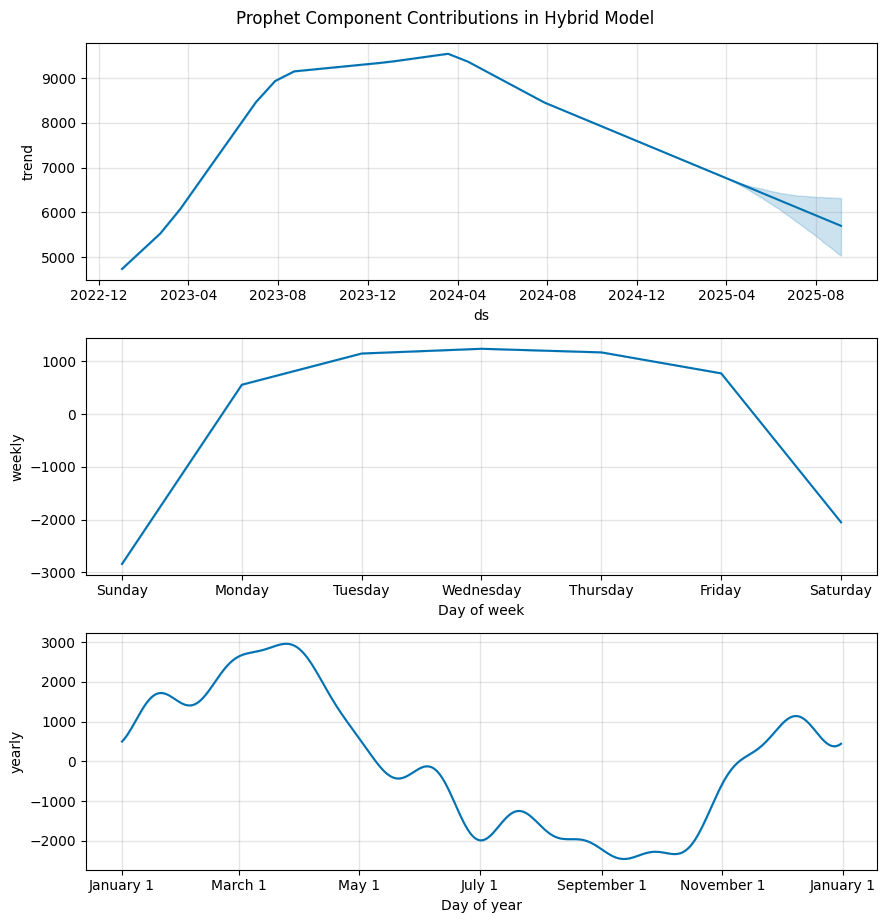

Hybrid model training complete.
Displaying SHAP plot for XGBoost (from Hybrid)...


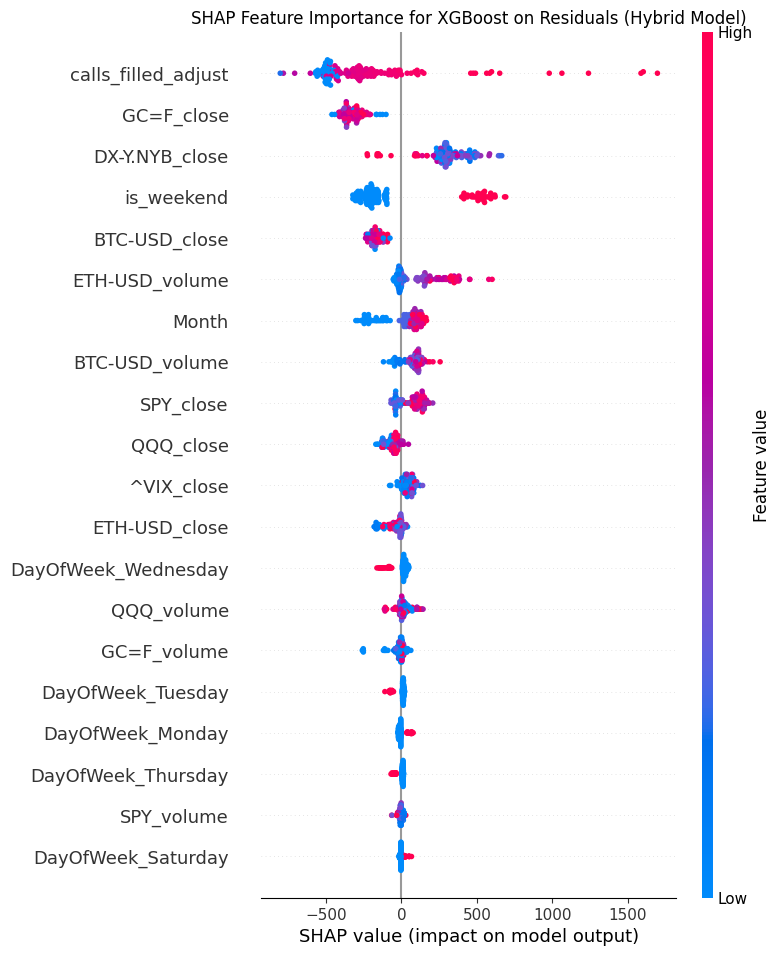

In [2]:
import shap
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from prophet import Prophet
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet

# Suppress a common SHAP warning related to TensorFlow internals
warnings.filterwarnings('ignore', category=UserWarning, module='shap.explainers._deep.deep_tf')

print("--- Preparing data and models for interpretation ---")

# --- Step 1: Create a single, final train/test split for consistent analysis ---
# This assumes 'df', 'df_scaled', 'tscv', 'features', and 'target' exist from the previous cell.
all_splits = list(tscv.split(df))
train_idx, test_idx = all_splits[-1]

# Unscaled data splits
train_df_final = df.iloc[train_idx]
test_df_final = df.iloc[test_idx]

# Scaled data splits (for LSTM)
train_scaled_final = df_scaled.iloc[train_idx]
test_scaled_final = df_scaled.iloc[test_idx]

# Prophet/NeuralProphet formatted data splits (correctly renaming 'Date' to 'ds')
train_prophet_format = train_df_final.reset_index().rename(columns={'Date': 'ds', target: 'y'})
test_prophet_format = test_df_final.reset_index().rename(columns={'Date': 'ds', target: 'y'})

# Re-create the sequence helper function for self-containment
def create_sequences(data, target_col, feature_cols, timesteps=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data[feature_cols].iloc[i:i+timesteps].values)
        y_seq.append(data[target_col].iloc[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


# --- Step 2: Run Interpretability Analysis (Train -> Interpret for each model) ---
print("\n--- Generating Model Interpretation Plots ---")

# 1. LSTM Interpretability with SHAP
try:
    print("\nTraining final LSTM model for interpretation...")
    # Create sequences using the final data split
    X_train_seq, y_train_seq = create_sequences(train_scaled_final, target, df_scaled.columns, timesteps=7)
    X_test_seq, _ = create_sequences(test_scaled_final, target, df_scaled.columns, timesteps=7)

    # **CRITICAL FIX**: Define and train a fresh model instance here
    final_lstm_model = Sequential([
        Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    final_lstm_model.compile(optimizer='adam', loss='mse')
    final_lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)
    print("LSTM training complete.")

    # Now run SHAP on the clean, newly-trained model
    background_data = X_train_seq[:100] # A subset of training data for the explainer
    explainer_lstm = shap.DeepExplainer(final_lstm_model, background_data)
    shap_values_lstm = explainer_lstm.shap_values(X_test_seq)

    # Average SHAP values over timesteps for a summary plot
    shap_values_lstm_avg = np.mean(shap_values_lstm[0], axis=1)

    # Create a 2D DataFrame for plotting (features averaged over timesteps)
    X_test_for_plot_df = pd.DataFrame(np.mean(X_test_seq, axis=1), columns=df_scaled.columns)

    print("Displaying SHAP plot for LSTM...")
    plt.figure()
    shap.summary_plot(shap_values_lstm_avg, X_test_for_plot_df, show=False)
    plt.title("SHAP Feature Importance for LSTM (Averaged over Timesteps)")
    plt.show()

except Exception as e:
    print(f"An error occurred during LSTM SHAP analysis: {e}")

# 2. NeuralProphet Interpretability
try:
    print("\nTraining final Neural Prophet model for interpretation...")
    final_np_model = NeuralProphet(epochs=50, batch_size=32)
    final_np_model.fit(train_prophet_format[['ds', 'y']], freq='D')
    print("Neural Prophet training complete.")

    print("Displaying plot for Neural Prophet...")
    fig_params = final_np_model.plot_parameters()
    plt.suptitle("NeuralProphet Model Components", y=1.02)
    plt.show()
except Exception as e:
    print(f"An error occurred during NeuralProphet plot generation: {e}")

# 3. Prophet + XGBoost Hybrid Interpretability
# 3a. Prophet Components
try:
    print("\nTraining final Prophet + XGBoost Hybrid model for interpretation...")
    # --- Prophet Part ---
    final_prophet_model = Prophet(weekly_seasonality=True)
    final_prophet_model.fit(train_prophet_format[['ds', 'y']])

    # Create forecast object needed for plotting components
    future_df = final_prophet_model.make_future_dataframe(periods=len(test_prophet_format))
    final_forecast_object = final_prophet_model.predict(future_df)

    print("Displaying component plot for Prophet (from Hybrid)...")
    fig_components = final_prophet_model.plot_components(final_forecast_object)
    plt.suptitle("Prophet Component Contributions in Hybrid Model", y=1.02)
    plt.show()

    # --- XGBoost Part (needs residuals from Prophet) ---
    # Calculate residuals on the training data
    train_forecast_prophet = final_prophet_model.predict(train_prophet_format[['ds']])
    train_residuals = train_prophet_format['y'] - train_forecast_prophet['yhat']

    # Define feature sets for XGBoost
    X_train_xgb = train_df_final[features]
    X_test_xgb = test_df_final[features]

    # Train XGBoost model on the residuals
    final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    final_xgb_model.fit(X_train_xgb, train_residuals)
    print("Hybrid model training complete.")

    # 3b. XGBoost with SHAP
    print("Displaying SHAP plot for XGBoost (from Hybrid)...")
    explainer_xgb = shap.TreeExplainer(final_xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_test_xgb)

    plt.figure()
    shap.summary_plot(shap_values_xgb, X_test_xgb, show=False)
    plt.title("SHAP Feature Importance for XGBoost on Residuals (Hybrid Model)")
    plt.show()

except Exception as e:
    print(f"An error occurred during Hybrid model analysis: {e}")